### Facebook Post Refiner

In [14]:
from typing import List, Sequence
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, START,  MessagesState, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq

load_dotenv()


# generate the chains
generation_prompt = ChatPromptTemplate.from_messages(
   [
       (
        "system", "You are a twitter techie influencer assitance tasked with writing excellent twitter post"
         "Generate the best twitter post possible for the user's request."
        "If the user provides citiques, respond with a revised version of your previous attempts"
       ),
       MessagesPlaceholder(variable_name="messages")
   ]
)

reflection_prompt = ChatPromptTemplate.from_messages(
   [
       (
        "system",  "You are a viral twitter influcer grading a tweet. Generate critique and recommendation for the user's tweet"
        "Always provide detailed recommendations, including request for length, virality, style, etc",
       ),
       MessagesPlaceholder(variable_name="messages")
   ]
)

llm =  ChatGroq(model='llama-3.3-70b-versatile')

generation_chain = generation_prompt | llm
reflection_chain = reflection_prompt | llm 






graph = StateGraph(MessagesState)

GENERATE="generate"
REFLECT = "reflect"

def generation_node(state):
    response = generation_chain.invoke(state)
    print("=================GENERATION NODE===================")
    print(response.content)
    return {
        "messages":[response]
    }

def reflection_node(state):
    response = reflection_chain.invoke(state)
    print("=================REFLECTION NODE===================")
    print(response.content)
    return [HumanMessage(content = response.content)]

# conditional statement to test where next to go
def should_continue(state):
    if(len(state["messages"]) > 6):
        return "end" 
    return "goto_generate"

graph.add_node(GENERATE, generation_node)
graph.add_node(REFLECT, reflection_node)

graph.set_entry_point(GENERATE)
# graph.add_edge(START,GENERATE)
graph.add_edge(GENERATE, REFLECT)
#add the conditional edges
graph.add_conditional_edges(
    REFLECT,
    should_continue,
    {
        "end":END,
        "goto_generate":GENERATE
    }
)

graph.add_edge(REFLECT, END)
# graph.add_edge(REFLECT, GENERATE)


app = graph.compile()
print(app.get_graph().draw_mermaid())
app.get_graph().print_ascii()
print("="*80)

response = app.invoke({
    "messages":[
        ("user","Write a facebook post about Lagos hustle")
    ]
})

# lines = '='*30
print(f"{lines}RAW RESPONSE{lines}")
print(response)

print();print()

print(f"{lines}CONTENT RESPONSE{lines}")
final_output =response["messages"][-1].content
print(final_output)

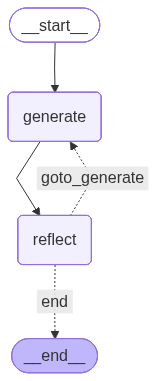

In [15]:
app

### Sample Funny Joke Detector

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# 1. Define our State
class State(TypedDict):
    joke: str
    is_funny: bool

# 2. Define our Nodes
def generate_joke(state: State):
    return {"joke": "Why did the programmer quit? Because he didn't get arrays."}

def refine_joke(state: State):
    return {"joke": "Why did the programmer quit his job? Because he didn't get arrays (a raise). Get it?"}

# 3. The Routing Function (The "Signpost")
def check_length(state: State):
    if len(state["joke"]) < 50:
        return "too_short"
    return "good_to_go"

# 4. Build the Graph
workflow = StateGraph(State)

workflow.add_node("generator", generate_joke)
workflow.add_node("refiner", refine_joke)

workflow.set_entry_point("generator")

# Add the conditional edge
workflow.add_conditional_edges(
    "generator",         # The source node
    check_length,        # The routing function
    {                    # The conditional map
        "too_short": "refiner", 
        "good_to_go": END
    }
)

workflow.add_edge("refiner", END)

app = workflow.compile()

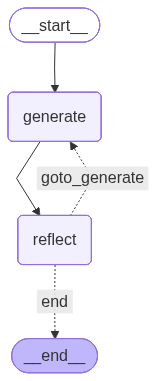

In [16]:
app

In [17]:
from typing import Literal
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, MessagesState
from dotenv import load_dotenv

load_dotenv()

# 1. Setup the LLM
llm = ChatGroq(model='llama-3.3-70b-versatile')

# 2. Define Prompts
gen_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert Facebook Content Creator. Write a high-engagement post. "
               "If you receive a critique, rewrite the post to address every point specifically."),
    MessagesPlaceholder(variable_name="messages"),
])

reflect_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a Facebook Viral Strategist. Grade the post on a scale of 1-10. "
               "Criteria: Hook (0-3), Relatability (0-3), Formatting/Emojis (0-4). "
               "If the total score is 8 or higher, start your response with 'PASSED'. "
               "Otherwise, start with 'FAILED' and provide a detailed critique."),
    MessagesPlaceholder(variable_name="messages"),
])

# 3. Define Nodes
def generation_node(state: MessagesState):
    # This node writes or rewrites the post
    response = gen_prompt.pipe(llm).invoke(state)
    return {"messages": [response]}

def reflection_node(state: MessagesState):
    # This node critiques the latest post
    response = reflect_prompt.pipe(llm).invoke(state)
    # We return this as a HumanMessage so the Generator thinks the 'user' gave feedback
    return {"messages": [HumanMessage(content=response.content)]}

# 4. The Conditional Edge (The Router)
def should_continue(state: MessagesState) -> Literal["reflect", "end"]:
    last_message = state["messages"][-1].content
    
    # If the strategist says PASSED or we've gone on too long (safety break)
    if "PASSED" in last_message or len(state["messages"]) > 6:
        return "end"
    return "reflect"

# 5. Build the Graph
workflow = StateGraph(MessagesState)

workflow.add_node("generate", generation_node)
workflow.add_node("reflect", reflection_node)

workflow.set_entry_point("generate")

# The logic: After generating, always check if we need to reflect
workflow.add_conditional_edges(
    "generate",
    should_continue,
    {
        "reflect": "reflect",
        "end": END
    }
)

# After reflecting, always go back to generate to fix the post
workflow.add_edge("reflect", "generate")

app = workflow.compile()

# 6. Run it
# inputs = {"messages": [HumanMessage(content="Write a facebook post about Lagos hustle")]}
# for chunk in app.stream(inputs, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Write a facebook post about Lagos hustle
================================== Ai Message ==================================

**POST**

Lagos, the city that never sleeps! Where the hustle is real and the grind is relentless. From the bustling streets of Ikeja to the vibrant markets of Balogun, every day is a struggle to make ends meet.

But despite the chaos and the noise, there's a certain energy that pulses through the veins of this city. An energy that drives us to keep pushing, to keep striving, to keep hustling.

So to all my Lagosians out there, I see you! I see the mama putting in extra hours at the market to feed her family. I see the young entrepreneur working tirelessly to turn his passion into a business. I see the okada rider braving the traffic to make a living.

Your hustle is real, and it's inspiring. Let's celebrate the spirit of Lagos, the city that makes us stronger, tougher, and more resil

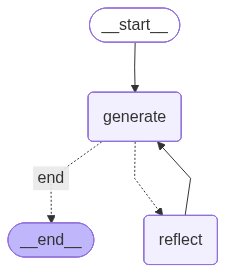

In [5]:
app

In [ ]:
from langchain_core.prompt import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph

